In [65]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

## Исходные данные

In [2]:
data = pd.read_csv("C:\\Users\\Виктория\\PycharmProjects\\TextCorrector\\Data\\NLPData\\train.csv")
test_data = pd.read_csv("C:\\Users\\Виктория\\PycharmProjects\\TextCorrector\\Data\\NLPData\\test.csv")

In [3]:
data.shape

(7613, 5)

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(f"Percent of NAN values in keyword: {round(sum(data['keyword'].isna()) / len(data['keyword']) * 100, 2)}%")
print(f"Percent of NAN values in location: {round(sum(data['location'].isna()) / len(data['location']) * 100, 2)}%")

Percent of NAN values in keyword: 0.8%
Percent of NAN values in location: 33.27%


Baseline score: 57.03402075397347


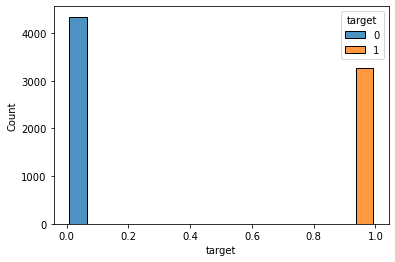

In [6]:
sns.histplot(data, x="target", hue="target", shrink=.8, alpha=.8)
print(f"Baseline score: {len(data[data['target']==0])/len(data['target'])* 100}")

## Предобработка данных

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
data["text"].apply(lambda tweet: tweet.lower())

0       our deeds are the reason of this #earthquake m...
1                  forest fire near la ronge sask. canada
2       all residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       just got sent this photo from ruby #alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @thetawniest the out of control w...
7610    m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

In [9]:
count_vectorizer = CountVectorizer()

In [10]:
# Пример построения векторов
words = []
for text in data.loc[:2, "text"].values:
    words.extend(text.split())
print(set(words))
print(f"The amount of unique words in first three rows: {len(set(words))}")

{'near', 'this', '#earthquake', 'are', 'Canada', 'of', 'asked', 'evacuation', 'ALLAH', 'being', 'expected', 'officers.', 'by', 'Sask.', 'residents', 'the', "'shelter", 'Our', 'shelter', 'Forest', 'All', 'notified', "place'", 'La', 'fire', 'Forgive', 'to', 'or', 'other', 'Reason', 'Ronge', 'us', 'May', 'orders', 'No', 'in', 'Deeds', 'place', 'all'}
The amount of unique words in first three rows: 39


In [11]:
example_vectors =  count_vectorizer.fit_transform(data.loc[:2, "text"])
print(example_vectors.shape)
print(example_vectors.todense())

(3, 36)
[[1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [1 0 2 1 1 1 0 0 0 1 1 0 0 0 2 0 0 0 1 1 0 1 1 1 1 0 2 0 1 0 0 2 0 0 1 0]]


In [12]:
sep_index = int(0.7*example_vectors.shape[0])
example_vectors[:sep_index].todense()

matrix([[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]], dtype=int64)

In [13]:
# Преобразование данных в векторы
text_vectors = count_vectorizer.fit_transform(data.text)
# Тестовую выборку необходимо преобразовать тем же алгоритмом, который был применен к обучающей выборке
test_text_vectors = count_vectorizer.transform(test_data.text)
print((text_vectors.todense()).shape, (test_text_vectors.todense()).shape)

(7613, 21637) (3263, 21637)


In [14]:
# Разбиение тренировочных данных на тренировычную и тестовую подвыборки
sep_index = int(text_vectors.shape[0]*0.7)

X_train_vectors, X_valid_vectors = text_vectors[:sep_index], text_vectors[sep_index:]
y_train, y_valid  = data["target"][:sep_index], data["target"][sep_index:]

X_train_vectors.shape, X_valid_vectors.shape, y_train.shape, y_valid.shape

((5329, 21637), (2284, 21637), (5329,), (2284,))

## Построение классификатора только на основе текста каждого из твитов

In [154]:
from sklearn.linear_model import LogisticRegression

In [16]:
lr = LogisticRegression(n_jobs=-1, max_iter=500)

In [17]:
lr.fit(X_train_vectors, y_train)

LogisticRegression(max_iter=500, n_jobs=-1)

In [18]:
lr.score(X_valid_vectors, y_valid)

0.7675131348511384

# Добавление новых признаков

In [19]:
from scipy.sparse import csr_matrix

In [20]:
new_data_features = pd.DataFrame(index=data.index)
new_test_features = pd.DataFrame(index=test_data.index)

In [21]:
# Добавление ключевых слов
data["keyword"].nunique()

221

In [22]:
# Уместно будет также представить ключевые слова в виде разряженной матрицы
new_data_features = pd.get_dummies(data=data["keyword"], columns=["keyword"], prefix="keyword")
new_test_features = pd.get_dummies(data=test_data["keyword"], columns=["keyword"], prefix="keyword")

In [23]:
# матрица станет избыточно большой 
data["location"].nunique()

3341

In [24]:
# Добавим признак, отражающий содержит ли твит упоминание локации.
def column_contains(data, search_column, column_to_find, fill_value=0):
    col_mentioned = []
    filled_data = data.fillna({column_to_find:fill_value})
    for row in filled_data.iterrows():
        col_mentioned.append(int(row[1].loc[column_to_find] != 0 and row[1].loc[column_to_find] in row[1].loc[search_column]))
    return col_mentioned    

In [25]:
new_data_features["location_mentioned"] = column_contains(data, "text", "location")
new_test_features["location_mentioned"] = column_contains(test_data, "text", "location")

In [26]:
percent = round(len(new_data_features[new_data_features["location_mentioned"] == 1]) / len(new_data_features) * 100, 2)
f"Percent of tweets which contains location in train data is {percent}%"

'Percent of tweets which contains location in train data is 0.79%'

In [27]:
# Добавим признак наличия ссылки в твите
new_test_features["contains_link"] = test_data.text.str.contains("http://").apply(int)
new_data_features["contains_link"] = data.text.str.contains("http://").apply(int)

In [28]:
new_data_features["contains_link"].value_counts()

0    4009
1    3604
Name: contains_link, dtype: int64

In [15]:
import re
# Добавим признак, отражающий является ли данный твит ответом
def is_answer(tweet):
    pattern  = r"@\w+"
    if re.search(pattern, tweet):
        return 1
    else:
        return 0

In [30]:
new_data_features["is_answer"] = data["text"].apply(is_answer)
new_test_features["is_answer"] = test_data["text"].apply(is_answer)
new_data_features["is_answer"].value_counts()

0    5604
1    2009
Name: is_answer, dtype: int64

## Преобразование новых признаков

In [31]:
# Представления новых признаков в формате разряженной матрицы
sparsed_new_data_features = csr_matrix(new_data_features.values)
sparsed_new_test_features = csr_matrix(new_test_features.values)

In [32]:
sparsed_new_train_features = sparsed_new_data_features[:sep_index]
sparsed_new_valid_features = sparsed_new_data_features[sep_index:]
sparsed_new_train_features.shape, sparsed_new_valid_features.shape

((5329, 224), (2284, 224))

In [33]:
new_X_train_vectors = hstack([X_train_vectors, sparsed_new_train_features])
new_X_valid_vectors = hstack([X_valid_vectors, sparsed_new_valid_features])

In [34]:
new_X_train_vectors.shape, new_X_valid_vectors.shape

((5329, 21861), (2284, 21861))

## Построение модели с учетом новых признаков 

In [35]:
new_lr = LogisticRegression(n_jobs=-1, max_iter=500)
new_lr.fit(new_X_train_vectors, y_train)
new_lr.score(new_X_valid_vectors, y_valid)

0.771015761821366

Результат превышает прежыжущую версию модели всего на один процент, что неприемлемо.
Это может происходит в следствие того что столбец is_answer создает мультиколлинеарность со всеми столбцами, отображающие ответы;
Также пока не был в полной мере учтен признак локации 

In [36]:
# Добавим к новым признакам так же локацию в формате разряженной матрицы
location_dummies = pd.DataFrame(index=data.index)
location_test_dummies = pd.DataFrame(index=test_data.index)

In [37]:
location_dummies = pd.get_dummies(data["location"], prefix="loc")
location_test_dummies = pd.get_dummies(test_data["location"], prefix="loc")

In [38]:
new_data_features = new_data_features.join(location_dummies)
new_test_features = new_test_features.join(location_test_dummies)

In [6]:
# Внесем в наши исходные данные колонку, отражающую является ли твит ответом,
# А потом удалим из текста все слова, содержащие символ "@"

def delete_answers(tweet):
    pattern = r"@\w+"
    return re.sub(pattern, "", tweet)

data["is_answer"] = data["text"].apply(is_answer)
data["text"] = data["text"].apply(delete_answers)

In [40]:
test_data["is_answer"] = test_data["text"].apply(is_answer)
test_data["text"] = test_data["text"].apply(delete_answers)

In [41]:
count_vec = CountVectorizer()
text_vectors = count_vec.fit_transform(data.text)
# Тестовую выборку необходимо преобразовать тем же алгоритмом, который был применен к обучающей выборке
test_text_vectors = count_vec.transform(test_data.text)
print((text_vectors.todense()).shape, (test_text_vectors.todense()).shape)

(7613, 19425) (3263, 19425)


In [42]:
sparsed_new_data_features = csr_matrix(new_data_features.values)
sparsed_new_test_features = csr_matrix(new_test_features.values)

In [43]:
X_train_vectors, X_valid_vectors = text_vectors[:sep_index], text_vectors[sep_index:]

In [44]:
sparsed_new_train_features = sparsed_new_data_features[:sep_index]
sparsed_new_valid_features = sparsed_new_data_features[sep_index:]

In [45]:
new_X_train_vectors = hstack([X_train_vectors, sparsed_new_train_features])
new_X_valid_vectors = hstack([X_valid_vectors, sparsed_new_valid_features])

## Построение модели, в которой учтена локация, а размерность снижена путем удаления меток ответов 

In [46]:
new_lr = LogisticRegression(n_jobs=-1, max_iter=10000)
new_lr.fit(new_X_train_vectors, y_train)
new_lr.score(new_X_valid_vectors, y_valid)

0.7644483362521891

# It was the first attempt

Столбцы location и keyword нельзя было преобразовывать через get_dummies, т.к. он разбивал столбцы на уникальные строки а не на уникальные слова из всех строк. В этот раз применим разбиение на векторы к каждому из этих столбцов

In [86]:
# Осстанется в качестве примера, хотя в дальнейшем применнено не будет 
#new_data["text"] = data["text"] + (" keyword_" + data["keyword"]).fillna("") + (" location_" + data["location"]).fillna("")

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score

In [13]:
class Vectors:
    def __init__(self, data:pd.DataFrame, test_data:pd.DataFrame):
        self.vectorizer = CountVectorizer()
        
        self.y = data["target"]
        self.data = data.drop("target", axis="columns").copy()
        self.test_data = test_data.copy()
        
        self.data_text_vectors = self.vectorizer.fit_transform(self.data["text"])
        self.test_data_text_vectors = self.vectorizer.transform(self.test_data["text"])
    
        self.data["keyword"].fillna("", inplace=True)
        self.test_data["keyword"].fillna("", inplace=True)
        self.data_keyword_vectors = self.vectorizer.fit_transform(self.data["keyword"])
        self.test_data_keyword_vectors = self.vectorizer.transform(self.test_data["keyword"])
        
        self.data["location"].fillna("", inplace=True)
        self.test_data["location"].fillna("", inplace=True)
        self.data_location_vectors = self.vectorizer.fit_transform(self.data["location"])
        self.test_data_location_vectors = self.vectorizer.transform(self.test_data["location"])
        
        self.data_vectors = hstack([self.data_text_vectors, self.data_keyword_vectors, self.data_location_vectors])
        self.test_data_vectors = hstack([self.test_data_text_vectors, self.test_data_keyword_vectors, self.test_data_location_vectors])
    

    def add_feature(self, data_column, test_data_column):    
        self.data_vectors = csr_matrix(hstack([self.data_vectors, data_column.values.reshape(-1, 1)]))
        self.test_data_vectors = csr_matrix(hstack([self.test_data_vectors, test_data_column.values.reshape(-1, 1)]))
        
        
    def review_text_vectors(self):
        self.data_text_vectors = self.vectorizer.fit_transform(self.data["text"])
        self.test_data_text_vectors = self.vectorizer.transform(self.test_data["text"])
        self.data_vectors = hstack([self.data_text_vectors, self.data_keyword_vectors, self.data_location_vectors])
        self.test_data_vectors = hstack([self.test_data_text_vectors, self.test_data_keyword_vectors, self.test_data_location_vectors])
        
        
    def delete_elements(self, change_vectors=True, element="answer"):
        patterns = {"answer": r"@\w+", "link": r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"}
        pattern = patterns.get(element, r"@\w+")
        self.data["text"] = self.data["text"].apply(lambda tweet: re.sub(pattern, "", tweet))
        self.test_data["text"] = self.test_data["text"].apply(lambda tweet: re.sub(pattern, "", tweet))
        
        if change_vectors:
            self.review_text_vectors()
            
            
    def get_splitted_vectors(self, train_size=0.7, random_split=False, random_state=17):
        if random_split:
            X_train_vectors, X_valid_vectors, y_train, y_valid = train_test_split(self.data_vectors,
                                                                                                  self.y,
                                                                                                  train_size=train_size,
                                                                                                  random_state=random_state)
        else:
            sep_index = int(train_size*self.data_vectors.shape[0])
            
            X_train_vectors, X_valid_vectors = self.data_vectors[:sep_index], self.data_vectors[sep_index:]
            y_train, y_valid = self.y[:sep_index], self.y[sep_index:]
        return X_train_vectors, X_valid_vectors, y_train, y_valid

In [17]:
vectors = Vectors(data, test_data)
data_vectors = vectors.data_vectors
test_data_vectors = vectors.test_data_vectors

In [18]:
print(f"Shape of data_vectors is {data_vectors.shape}")
print(f"Shape of test_data_vectors is {test_data_vectors.shape}")

Shape of data_vectors is (7613, 25137)
Shape of test_data_vectors is (3263, 25137)


In [19]:
X_train_vectors, X_valid_vectors, y_train, y_valid = vectors.get_splitted_vectors(random_split=True)
X_train_vectors.shape, X_valid_vectors.shape, y_train.shape, y_valid.shape

((5329, 25137), (2284, 25137), (5329,), (2284,))

Опробуем различные комбинации параметров на модели без настройки гиперпараметров

In [9]:
lr = LogisticRegression(max_iter=500, n_jobs=-1)

In [10]:
def fit_show_result(X_train, y_train, X_valid, y_valid):
    lr.fit(X_train, y_train)
    print(f"Score: {lr.score(X_valid, y_valid)}")
    print(f"RocAuc: {roc_auc_score(y_valid, lr.predict(X_valid))}")

In [20]:
#Исходные данные:
fit_show_result(X_train_vectors, y_train, X_valid_vectors, y_valid)

Score: 0.8007880910683012
RocAuc: 0.790632944956561


In [40]:
# Добавим признак отражающий является ли сообщение ответом и удаоим все адреса из сообщений
without_adress_vectors = Vectors(data, test_data)
without_adress_vectors.add_feature(data['text'].apply(is_answer), test_data['text'].apply(is_answer))
wa_X_train_vectors, wa_X_valid_vectors, wa_y_train, wa_y_valid = without_adress_vectors.get_splitted_vectors(random_split=True)

print("After adding the 'is_answer' feature:")
print(wa_X_train_vectors.shape, wa_X_valid_vectors.shape, wa_y_train.shape, wa_y_valid.shape, end="\n\n")

without_adress_vectors.delete_elements(element="answer")
wa_X_train_vectors, wa_X_valid_vectors, wa_y_train, wa_y_valid = without_adress_vectors.get_splitted_vectors(random_split=True)

print("After deleting all adresses in every tweet:")
print(wa_X_train_vectors.shape, wa_X_valid_vectors.shape, wa_y_train.shape, wa_y_valid.shape, end="\n\n")

fit_show_result(wa_X_train_vectors, wa_y_train, wa_X_valid_vectors, wa_y_valid)

After adding the 'is_answer' feature:
(5329, 25138) (2284, 25138) (5329,) (2284,)

After deleting all adresses in every tweet:
(5329, 22925) (2284, 22925) (5329,) (2284,)

Score: 0.8029772329246935
RocAuc: 0.7933788779186748


In [58]:
# Добавим признак отражающий содержит ли сообщение ссылку и удаоим все ссыдки из твитов
without_link_vectors = Vectors(data, test_data)
without_link_vectors.add_feature(data['text'].str.contains("http://").apply(int), test_data['text'].str.contains("http://").apply(int))
wl_X_train_vectors, wl_X_valid_vectors, wl_y_train, wl_y_valid = without_link_vectors.get_splitted_vectors(random_split=True)

print("After adding the 'contains_link' feature:")
print(wl_X_train_vectors.shape, wl_X_valid_vectors.shape, wl_y_train.shape, wl_y_valid.shape, end="\n\n")

without_link_vectors.delete_elements(element="link")
wl_X_train_vectors, wl_X_valid_vectors, wl_y_train, wl_y_valid = without_link_vectors.get_splitted_vectors(random_split=True)

print("After deleting all links in every tweet:")
print(wl_X_train_vectors.shape, wl_X_valid_vectors.shape, wl_y_train.shape, wl_y_valid.shape, end="\n\n")

#set(without_link_vectors.data["text"])
fit_show_result(wl_X_train_vectors, wl_y_train, wl_X_valid_vectors, wl_y_valid)

After adding the 'contains_link' feature:
(5329, 25138) (2284, 25138) (5329,) (2284,)

After deleting all links in every tweet:
(5329, 20540) (2284, 20540) (5329,) (2284,)

Score: 0.7955341506129597
RocAuc: 0.7852892549093008


In [16]:
# Удалим и ответы и ссылкиб добавив соотвеетствующие признаки
wla_vectors =  Vectors(data, test_data)

wla_vectors.add_feature(data['text'].str.contains("http://").apply(int), test_data['text'].str.contains("http://").apply(int))
wla_vectors.add_feature(data['text'].apply(is_answer), test_data['text'].apply(is_answer))
wla_X_train_vectors, wla_X_valid_vectors, wla_y_train, wla_y_valid = wla_vectors.get_splitted_vectors(random_split=True)


print("After adding the bobth of features:")
print(wla_X_train_vectors.shape, wla_X_valid_vectors.shape, wla_y_train.shape, wla_y_valid.shape, end="\n\n")

wla_vectors.delete_elements(element="link")
wla_vectors.delete_elements(element="anser")
wla_X_train_vectors, wla_X_valid_vectors, wla_y_train, wla_y_valid = wla_vectors.get_splitted_vectors(random_split=True)

print("After deleting the both types of elements in every tweet:")
print(wla_X_train_vectors.shape, wla_X_valid_vectors.shape, wla_y_train.shape, wla_y_valid.shape, end="\n\n")

fit_show_result(wla_X_train_vectors, wla_y_train, wla_X_valid_vectors, wla_y_valid)

After adding the bobth of features:
(5329, 25139) (2284, 25139) (5329,) (2284,)

After deleting the both types of elements in every tweet:
(5329, 18328) (2284, 18328) (5329,) (2284,)

Score: 0.7981611208406305
RocAuc: 0.7883073635612122


The best result was shown by model which includes feature that demonstrates does the paticular tweet contains adress of an answer, but text vectors doesn't include adresses. And shape of that dataset is (7613, 22925).
Nevertheless the model that contains only 18328 columns shows not strongly different result.

## Regularize logistic regression with the best dataset

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

In [46]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.linspace(1, 100, 101)

lr_cv = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=2)
lr_cv.fit(wa_X_train_vectors, wa_y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.0min finished


LogisticRegressionCV(Cs=array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
         8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
        16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  22.78,  23.77,
        24.76,  25.75,  26.74,  27.73,  28.72,  29.71,  30.7 ,  31.69,
        32.68,  33.67,  34.66,  35.65,  36.64,  37.63,  38.62,  39.61,
        40.6 ,  41.59,  42.58,  43.57,  44.56,  45.55,  46.54,  47.53,
        48.52,  49.51,  50.5 ,  51.49,  52.48,  53.47,  54.46,  55.45,
        56.44,  57.43,  58.42,  59.41,  60.4 ,  61.39,  62.38,  63.37,
        64.36,  65.35,  66.34,  67.33,  68.32,  69.31,  70.3 ,  71.29,
        72.28,  73.27,  74.26,  75.25,  76.24,  77.23,  78.22,  79.21,
        80.2 ,  81.19,  82.18,  83.17,  84.16,  85.15,  86.14,  87.13,
        88.12,  89.11,  90.1 ,  91.09,  92.08,  93.07,  94.06,  95.05,
        96.04,  97.03,  98.02,  99.01, 100.  ]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffl

<AxesSubplot:>

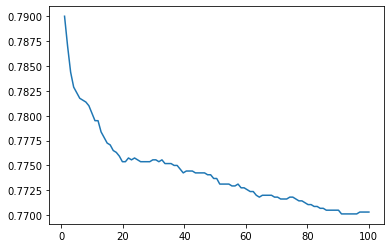

In [53]:
sns.lineplot(x=c_values, y=np.mean(lr_cv.scores_[1], axis=0))

In [55]:
c_values = np.linspace(1*10**(-20), 1, 50)

lr_cv = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=2)
lr_cv.fit(wa_X_train_vectors, wa_y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   42.3s finished


LogisticRegressionCV(Cs=array([1.00000000e-20, 2.04081633e-02, 4.08163265e-02, 6.12244898e-02,
       8.16326531e-02, 1.02040816e-01, 1.22448980e-01, 1.42857143e-01,
       1.63265306e-01, 1.83673469e-01, 2.04081633e-01, 2.24489796e-01,
       2.44897959e-01, 2.65306122e-01, 2.85714286e-01, 3.06122449e-01,
       3.26530612e-01, 3.46938776e-01, 3.67346939e-01, 3.87755102e-01,
       4.08163265e-01, 4.28...
       6.53061224e-01, 6.73469388e-01, 6.93877551e-01, 7.14285714e-01,
       7.34693878e-01, 7.55102041e-01, 7.75510204e-01, 7.95918367e-01,
       8.16326531e-01, 8.36734694e-01, 8.57142857e-01, 8.77551020e-01,
       8.97959184e-01, 9.18367347e-01, 9.38775510e-01, 9.59183673e-01,
       9.79591837e-01, 1.00000000e+00]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=2, verbose=1)

0.7941454606312044


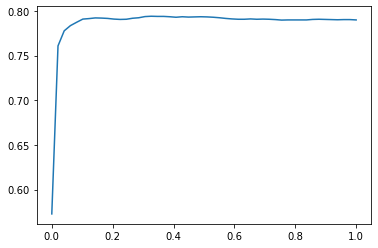

In [57]:
sns.lineplot(x=c_values, y=np.mean(lr_cv.scores_[1], axis=0))
print(np.mean(lr_cv.scores_[1], axis=0).max())

In [59]:
res_lr = LogisticRegression(C=0.8)
res_lr.fit(wa_X_train_vectors, wa_y_train)

LogisticRegression(C=0.8)

In [60]:
res_lr.score(wa_X_valid_vectors, wa_y_valid)

0.8051663747810858

## Sending answers to Kaggle

In [64]:
test_vectors = without_adress_vectors.test_data_vectors
predictions = res_lr.predict(test_vectors)